In [134]:
from pnca import ProxyNCA, remove_top_layer
import torchvision.models as models
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import numpy as np
from sklearn.utils import shuffle
import time

In [121]:
no_top_model = remove_top_layer(models.vgg16(pretrained=True))

In [122]:
sz_batch = 70
nb_samples = 100
sz_embed = 64
nb_classes = 50

In [ ]:
# select only small amount of classes for training while fine-tuning
path_cub = "cub-200/images"
img_size = 224
import os
import skimage.transform
import skimage
from skimage.io import imread, imsave
xs, ys = [], []
dns = [dn for dn in os.listdir(path_cub) if dn[0] != "."]
dns.sort()
for label, dn in enumerate(dns[:nb_classes]):
    print(label)
    for fn in (n for n in os.listdir(os.path.join(path_cub, dn)) if n[0] != "."):
        im_path = os.path.join(path_cub, dn, fn)
        im = imread(im_path)
        im = skimage.transform.resize(im, (224, 224, 3))
        im = np.reshape(im, (3, 224, 224))
        xs.append(im)
        ys.append(label)

In [124]:
xs = np.array(xs)
ys = np.array(ys)

In [125]:
idx_tr = np.where(ys < nb_classes)
idx_te = np.where(ys >= nb_classes)
xs_tr, xs_te = xs[idx_tr], xs[idx_te]
ys_tr, ys_te = ys[idx_tr], ys[idx_te]
# test set disabled

In [126]:
xs_tr, ys_tr = shuffle(xs_tr, ys_tr)
xs_tr, ys_tr = Variable(torch.FloatTensor(xs_tr)).cuda(), Variable(torch.LongTensor(ys_tr)).cuda()

In [127]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

In [128]:
# normalize(xs_tr.data) # inplace normalization
print()

In [129]:
xs[0].shape
zz = xs_tr.data.cpu().numpy()[0].reshape((224, 224, 3))

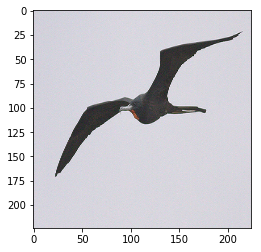

In [130]:
plt.imshow(zz)
plt.show()

In [131]:
model = ProxyNCA(no_top_model, sz_embed, nb_classes, sz_batch)
model.cuda()
params = list(filter(lambda x : x.requires_grad == True, model.parameters()))
# verify that no_top_model is frozen
assert any([p.requires_grad for p in model.no_top_model.parameters()]) == False

In [ ]:
t1 = time.time()
opt = torch.optim.Adam(params, lr=0.0001)
nb_epochs = 100 * 6 * 8

print("Training for {} epochs.".format(nb_epochs))

losses = []

for e in range(1, nb_epochs + 1):
    time_per_epoch_1 = time.time()
    for i in range(0, len(xs_tr) - sz_batch, sz_batch):
        x = xs_tr[i : i + sz_batch]
        y = ys_tr[i : i + sz_batch]
        opt.zero_grad()
        loss = model(x, y)
        loss.backward()
        opt.step()
    time_per_epoch_2 = time.time()
    losses.append(loss.data.cpu().numpy()[0])
    print("Epoch: {}, loss: {}, time (seconds): {:.2f}.".format(e, 
                                                  losses[-1],
                                                  time_per_epoch_2 - time_per_epoch_1)
         )
    

t2 = time.time()
print("Total training time (minutes): {:.2f}.".format((t2 - t1) / 60))

Training for 4800 epochs.
Epoch: 1, loss: 3.9526278972625732, time (seconds): 21.97.
Epoch: 2, loss: 3.8825509548187256, time (seconds): 21.92.
Epoch: 3, loss: 3.833444595336914, time (seconds): 21.96.
Epoch: 4, loss: 3.8261735439300537, time (seconds): 22.00.
Epoch: 5, loss: 3.78912353515625, time (seconds): 22.47.
Epoch: 6, loss: 3.782644271850586, time (seconds): 23.28.
Epoch: 7, loss: 3.730668306350708, time (seconds): 23.19.
Epoch: 8, loss: 3.6999528408050537, time (seconds): 23.20.
Epoch: 9, loss: 3.682451009750366, time (seconds): 23.22.
Epoch: 10, loss: 3.7206337451934814, time (seconds): 22.94.
Epoch: 11, loss: 3.7005436420440674, time (seconds): 23.09.
Epoch: 12, loss: 3.705880641937256, time (seconds): 22.50.
Epoch: 13, loss: 3.6689789295196533, time (seconds): 22.28.
Epoch: 14, loss: 3.6887590885162354, time (seconds): 22.35.
Epoch: 15, loss: 3.6801373958587646, time (seconds): 23.24.
Epoch: 16, loss: 3.6502702236175537, time (seconds): 23.22.
Epoch: 17, loss: 3.62274718284

Epoch: 138, loss: 3.380298614501953, time (seconds): 22.77.
Epoch: 139, loss: 3.3676018714904785, time (seconds): 23.88.
Epoch: 140, loss: 3.398838520050049, time (seconds): 23.91.
Epoch: 141, loss: 3.4086365699768066, time (seconds): 25.81.
Epoch: 142, loss: 3.369349956512451, time (seconds): 25.67.
Epoch: 143, loss: 3.4333207607269287, time (seconds): 25.61.
Epoch: 144, loss: 3.3795924186706543, time (seconds): 25.59.
Epoch: 145, loss: 3.389099597930908, time (seconds): 25.61.
Epoch: 146, loss: 3.4313149452209473, time (seconds): 25.41.
Epoch: 147, loss: 3.4340975284576416, time (seconds): 25.68.
Epoch: 148, loss: 3.375007152557373, time (seconds): 25.78.
Epoch: 149, loss: 3.3530492782592773, time (seconds): 25.61.
Epoch: 150, loss: 3.4252383708953857, time (seconds): 25.66.
Epoch: 151, loss: 3.420825242996216, time (seconds): 25.56.
Epoch: 152, loss: 3.3957300186157227, time (seconds): 25.61.
Epoch: 153, loss: 3.3983712196350098, time (seconds): 25.74.
Epoch: 154, loss: 3.4425818920

In [ ]:
import matplotlib.pyplot as plt

In [140]:
1e-10

8e-10

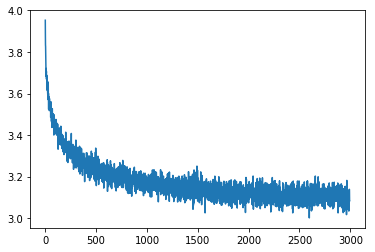

In [135]:
plt.plot(losses)
plt.show()

In [142]:
torch.save(model.state_dict(), './c50-e3000-lr0001.pt')
# net.load_state_dict(torch.load('./c50-e3000-lr0001.pt'))